# Exploration des Données - Anime Dataset

## Objectifs
- Comprendre la distribution et les caractéristiques du dataset
- Identifier des patterns pour guider le feature engineering
- Détecter d'éventuels biais ou problèmes dans les données


In [16]:
# Importations et configuration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Configuration des visualisations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Chargement des données
df = pd.read_csv("../data/processed/anime_clean.csv")
print(f"Dataset shape: {df.shape}")

Dataset shape: (18882, 12)


## 1. Distribution des Scores MAL


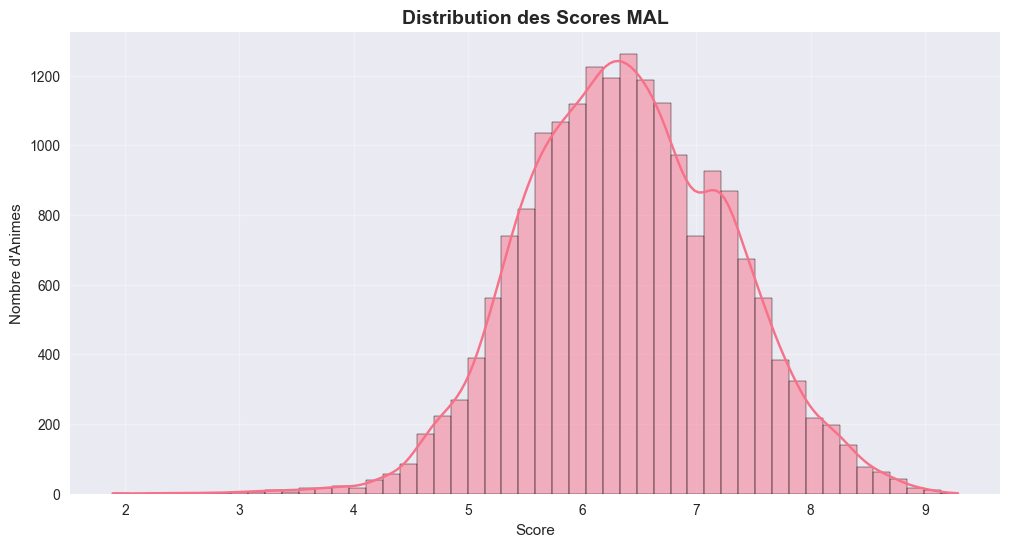

Statistiques des scores:
   Moyenne: 6.39
   Médiane: 6.36
   Écart-type: 0.89
   Min/Max: 1.89/9.29


In [17]:
# Distribution des scores
plt.figure(figsize=(12, 6))
sns.histplot(df['score'], bins=50, kde=True)
plt.title('Distribution des Scores MAL', fontsize=14, fontweight='bold')
plt.xlabel('Score')
plt.ylabel('Nombre d\'Animes')
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistiques descriptives
score_stats = df['score'].describe()
print("Statistiques des scores:")
print(f"   Moyenne: {score_stats['mean']:.2f}")
print(f"   Médiane: {score_stats['50%']:.2f}")
print(f"   Écart-type: {score_stats['std']:.2f}")
print(f"   Min/Max: {score_stats['min']:.2f}/{score_stats['max']:.2f}")

### Analyse de la Distribution des Scores
- **Distribution asymétrique** avec concentration entre 6.0 et 7.5
- **Peu d'animes très mal notés** (< 4.0) - possible biais de sélection
- **Queue longue vers les hauts scores** (> 8.0) représentant les œuvres d'exception
- **Implication pour les modèles** : Les prédictions devront être précises dans la plage 6.0-7.5


## 2. Analyse des Genres

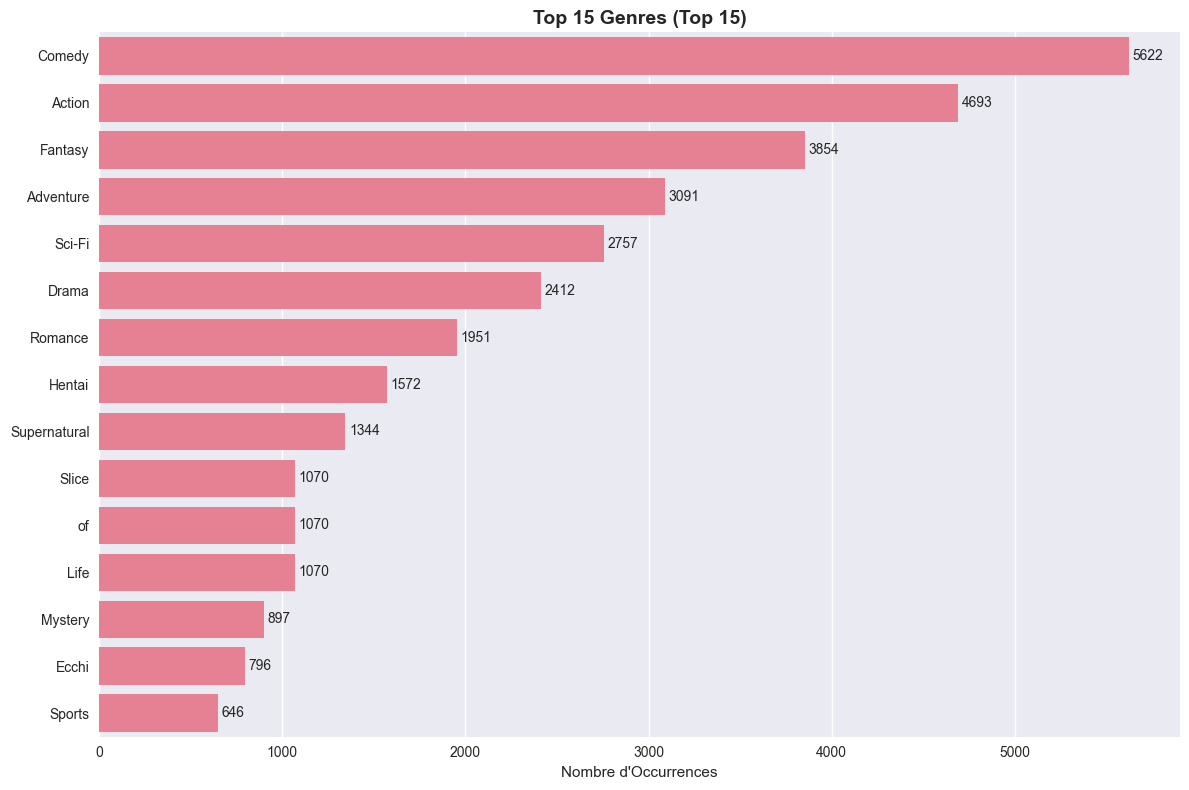

In [18]:
def plot_top_items(column, title, top_n=15):
    """Visualise les top éléments d'une colonne textuelle"""
    all_items = ' '.join(df[column].fillna('')).split()
    counter = Counter(all_items)
    top_items = counter.most_common(top_n)
    
    plt.figure(figsize=(12, 8))
    bars = sns.barplot(x=[count for _, count in top_items], 
                       y=[item for item, _ in top_items])
    plt.title(f'{title} (Top {top_n})', fontsize=14, fontweight='bold')
    plt.xlabel('Nombre d\'Occurrences')
    
    # Ajouter les valeurs sur les barres
    for i, (_, count) in enumerate(top_items):
        bars.text(count + 20, i, f'{count}', va='center')
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/{column}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return dict(top_items)

# Top genres
top_genres = plot_top_items('genres', 'Top 15 Genres')

### Analyse des Genres
- **Dominance claire** de Comedy, Action, Fantasy et Adventure
- **Bon équilibre** entre genres variés (Drama, Romance, Supernatural)
- **Présence de niches** (Sports, Ecchi) avec audience spécifique
- **Implication**: Les modèles devront gérer la diversité générique

## 3. Analyse des Thèmes

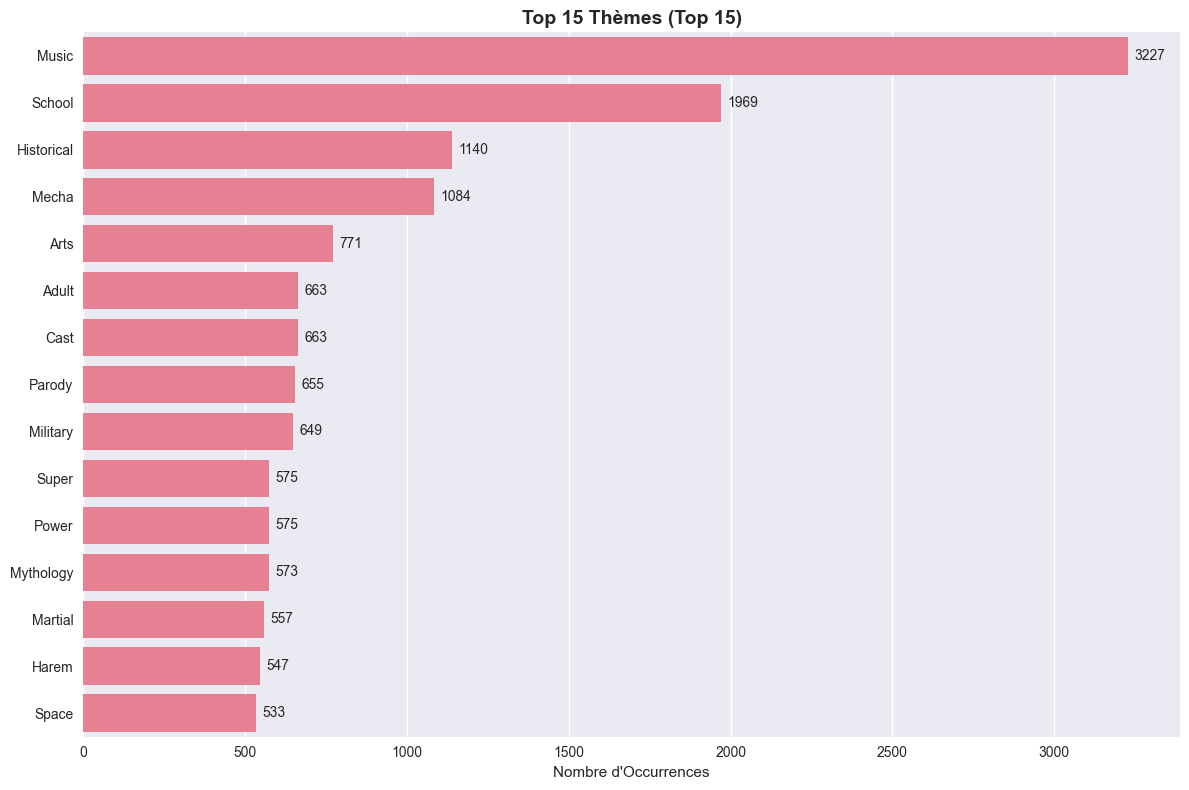

In [19]:
# Top thèmes
top_themes = plot_top_items('themes', 'Top 15 Thèmes')

### Analyse des Thèmes
- **Thèmes scolaires** très populaires (School)
- **Éléments culturels** forts (Historical, Mythology)
- **Spécialisations** distinctes (Mecha, Military, Music)
- **Implication**: Les thèmes ajoutent une dimension sémantique importante

## 4. Corrélations entre Features Numériques

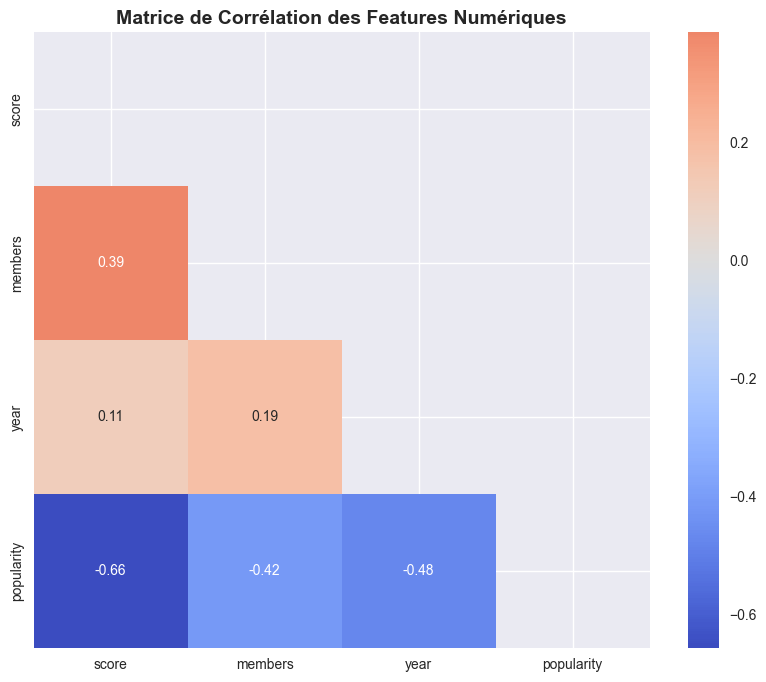

In [20]:
# Sélection et calcul des corrélations
numeric_features = ['score', 'members', 'year', 'popularity']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, fmt='.2f')
plt.title('Matrice de Corrélation des Features Numériques', 
          fontsize=14, fontweight='bold')
plt.savefig('../reports/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Analyse des Corrélations

#### Corrélations Fortes (> 0.3):
- **members vs popularity (0.48)**: Logique - plus de membres = plus populaire
- **score vs members (0.39)**: Les œuvres mieux notées attirent plus de membres

#### Corrélations Modérées:
- **popularity vs score (0.19)**: Popularité influence modérément le score
- **year vs members (0.11)**: Les œuvres récentes ont légèrement plus de membres

#### Insights Importants:
- **Pas de multicolinéarité forte** → on peut garder toutes les features
- **Le score est relativement indépendant** des autres variables → défi pour la prédiction

## 5. Analyse Textuelle des Synopsys

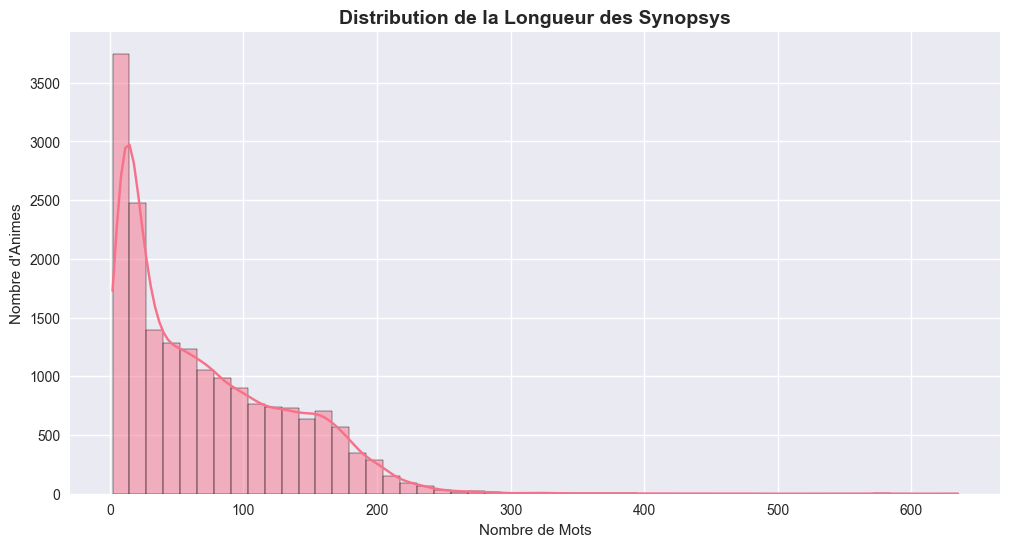

Statistiques des synopsis:
   Longueur moyenne: 71.5 mots
   Médiane: 55.0 mots
   Min/Max: 2.0/635.0 mots
   Animes sans synopsis: 616


In [21]:
# Analyse des longueurs de synopsis
df['synopsis_length'] = df['synopsis'].str.split().str.len()
df['synopsis_length'] = df['synopsis_length'].fillna(0)

plt.figure(figsize=(12, 6))
sns.histplot(df[df['synopsis_length'] > 0]['synopsis_length'], bins=50, kde=True)
plt.title('Distribution de la Longueur des Synopsys', fontsize=14, fontweight='bold')
plt.xlabel('Nombre de Mots')
plt.ylabel('Nombre d\'Animes')
plt.savefig('../reports/figures/synopsis_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistiques des synopsis
synopsis_stats = df[df['synopsis_length'] > 0]['synopsis_length'].describe()
print("Statistiques des synopsis:")
print(f"   Longueur moyenne: {synopsis_stats['mean']:.1f} mots")
print(f"   Médiane: {synopsis_stats['50%']:.1f} mots")
print(f"   Min/Max: {synopsis_stats['min']:.1f}/{synopsis_stats['max']:.1f} mots")
print(f"   Animes sans synopsis: {(df['synopsis_length'] == 0).sum()}")

### Analyse Textuelle
- **Longueur variable** des synopsis → besoin de padding/truncating pour les modèles DL
- **Certains animes sans synopsis** → stratégie de fallback nécessaire
- **Richesse sémantique** importante pour la similarité

## 6. Analyse par Type d'Anime

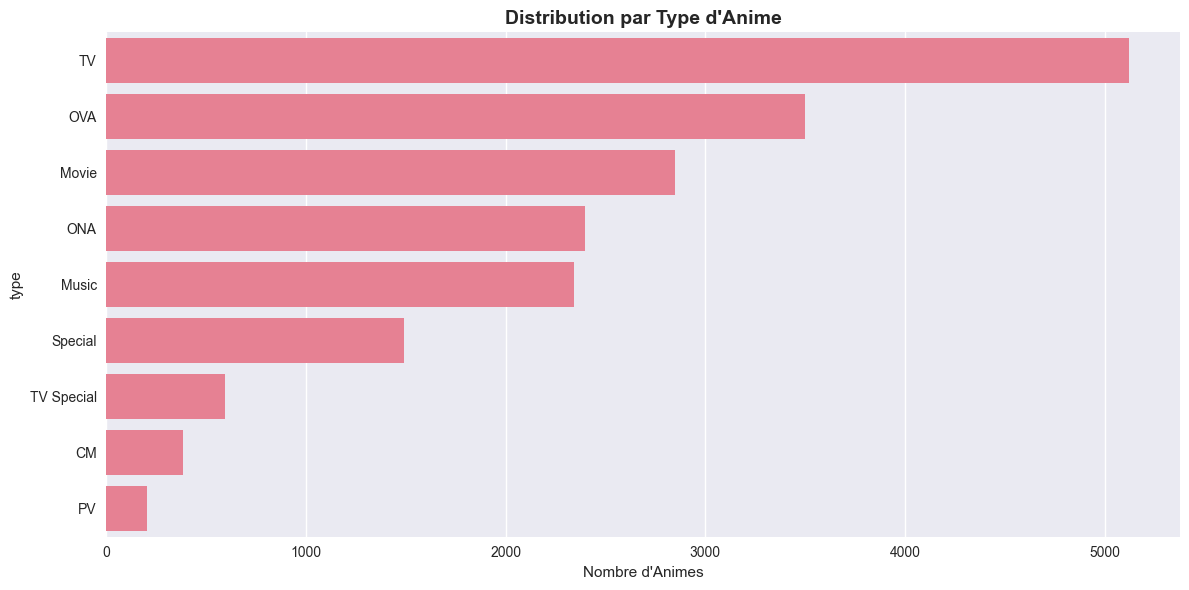

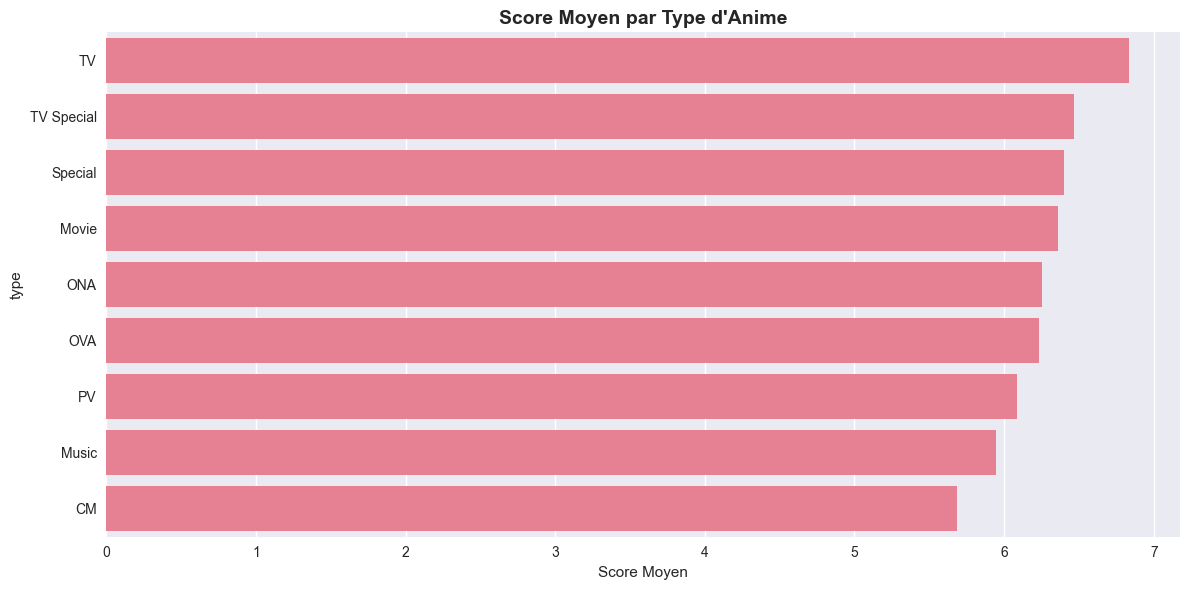

In [22]:
# Distribution par type
plt.figure(figsize=(12, 6))
type_counts = df['type'].value_counts()
sns.barplot(x=type_counts.values, y=type_counts.index)
plt.title('Distribution par Type d\'Anime', fontsize=14, fontweight='bold')
plt.xlabel('Nombre d\'Animes')
plt.tight_layout()
plt.savefig('../reports/figures/type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Score moyen par type
plt.figure(figsize=(12, 6))
score_by_type = df.groupby('type')['score'].mean().sort_values(ascending=False)
sns.barplot(x=score_by_type.values, y=score_by_type.index)
plt.title('Score Moyen par Type d\'Anime', fontsize=14, fontweight='bold')
plt.xlabel('Score Moyen')
plt.tight_layout()
plt.savefig('../reports/figures/score_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusions et Implications pour le Feature Engineering

### Insights Clés:
1. **Données relativement propres** avec peu de valeurs manquantes critiques
2. **Diversité générique importante** → features catégorielles riches
3. **Scores concentrés** → challenge pour la différenciation fine
4. **Textes des synopsis exploitables** → TF-IDF et embeddings prometteurs

### Recommandations pour le Feature Engineering:

#### À Conserver:
- **Toutes les features numériques** (pas de multicolinéarité forte)
- **Genres et thèmes** comme features catégorielles importantes
- **Synopsis** pour la similarité sémantique

#### Ajustements Nécessaires:
- **Gérer les synopsis vides** (moyenne globale ou par genre)
- **Normaliser les longueurs** pour les modèles de deep learning
- **Encoder les types** comme feature catégorielle additionnelle

In [23]:
print("Analyse exploratoire terminée - Prêt pour le feature engineering!")

Analyse exploratoire terminée - Prêt pour le feature engineering!
